<a href="https://colab.research.google.com/github/SiriosMEN/Data-science/blob/main/keras_resnet50/face_recogn_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Определение возраста покупателей

## Исследовательский анализ данных

Загрузим данные из датасета

In [ ]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, AveragePooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

In [ ]:
labels=pd.read_csv('/datasets/faces/labels.csv')
labels.info()
labels

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
file_name    7591 non-null object
real_age     7591 non-null int64
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17
...,...,...
7586,007608.jpg,14
7587,007609.jpg,37
7588,007610.jpg,28
7589,007611.jpg,20


В датасете 7591 фотография с метками возраста. Пропущенные значения отсутствуют.

In [ ]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


Явные выбросы в значениях возраста отсутствуют. Среднее и медианные значения близки друг к другу, распределение близко к нормальному.

Загрузим в загрузчик файлы с фотографиями:

In [ ]:
datagen = ImageDataGenerator(rescale=1./255)
train_data = datagen.flow_from_dataframe(dataframe = labels,directory = '/datasets/faces/final_files', x_col = 'file_name', 
                                         y_col = 'real_age',
                                         target_size = (224,224),batch_size = 32, class_mode = 'raw',seed=12345)

Found 7591 validated image filenames.


<div class="alert alert-block alert-info">Rescale делаем для того, чтобы привести все пиксели к одной шкале яркости для того, чтобы разная яркость на разных фотографиях не воспринималась моделью как отдельная фича.</div>

Построим график распределения возраста в выборке:

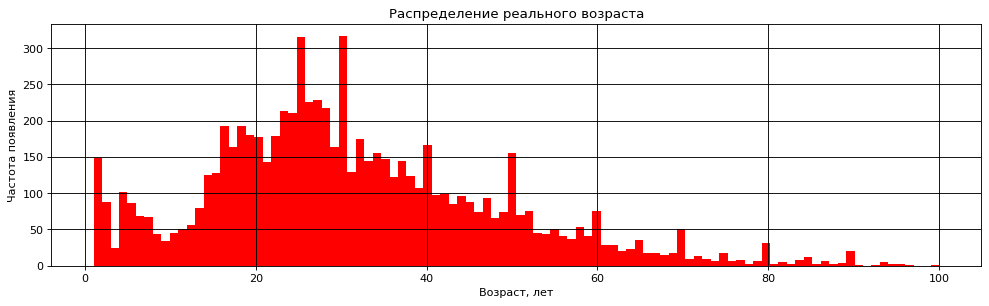

In [ ]:
plt.figure(figsize=(15,4),dpi=80)
plt.title('Распределение реального возраста')
plt.xlabel('Возраст, лет')
plt.ylabel('Частота появления')
plt.hist(x=labels['real_age'],bins=100,color='red')
plt.grid(True,which='both',color='black')
plt.show()

<div class="alert alert-block alert-info">Действительно. За счет того, что отрицательные значения отсутствуют, хвосты отличаются. Но по крайней мере по правому хвосту - на расстоянии трех станартных отклонений лежит минимальное количество значений.</div>

Распределение близко к нормальному. В выборке есть лидирующие по частоте значения возрастовв районе 30 лет.

Рассмотрим содержание фотографий и соотнесенных возрастов.

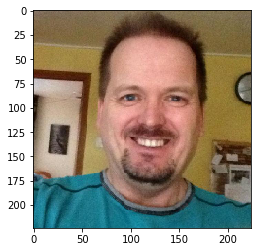

i= 0
Возраст: 50


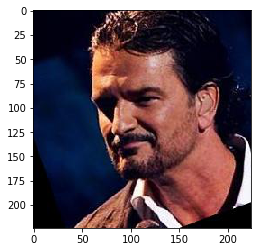

i= 1
Возраст: 51


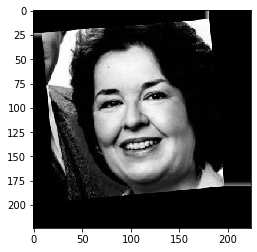

i= 2
Возраст: 49


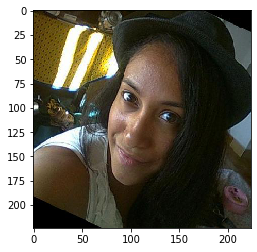

i= 3
Возраст: 23


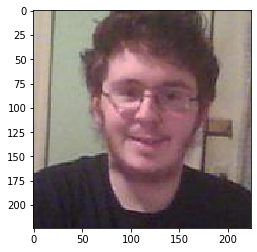

i= 4
Возраст: 21


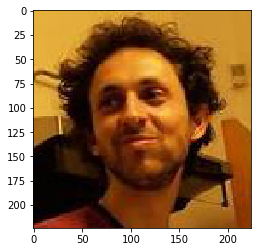

i= 5
Возраст: 30


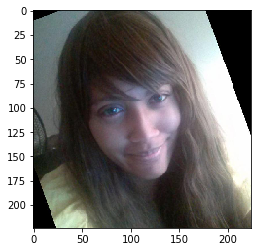

i= 6
Возраст: 24


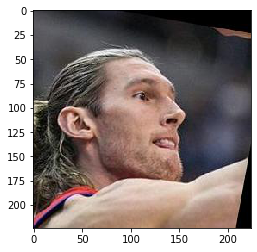

i= 7
Возраст: 29


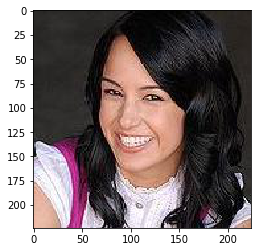

i= 8
Возраст: 32


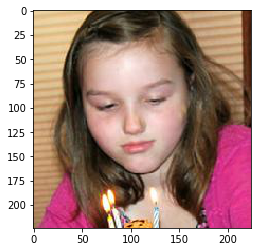

i= 9
Возраст: 9


In [ ]:
for i in range(0,10):
    plt.imshow(train_data[i][0][0])
    plt.show()
    print('i=',i)
    print('Возраст:',train_data[i][1][0])

### Вывод

В датасете представлены фоторафии 7.5 тысяч человек с соотнесенными метками реального возраста. БОльшую часть датасета и наиболее часто встречающиеся фотографии относятся к людям среднего возраста от 20 до 40 лет. С учетом того, что задачей является определение возраста покупателей, такое распределение должно положительно сказаться на решаемой задаче. Фотографии сделаны на разных фонах с разным освещением, людей разных расс, разного пола, что также должно дать положительный вклад в результаты работы модели.

## Обучение модели

Напишем функцию создания и обучения модели:

```python
def load_train(path):
    labels=pd.read_csv(path+'labels.csv')
    datagen = ImageDataGenerator(rescale=1./255)
    train_data = datagen.flow_from_dataframe(dataframe = labels,
                                             directory = path+'/final_files',
                                             x_col = 'file_name', 
                                             y_col = 'real_age',
                                             target_size = (224,224),
                                             batch_size = 32,
                                             class_mode = 'raw',
                                             seed=12345)
      
    return train_data

def load_test(path):
    labels=pd.read_csv(path+'labels.csv')
    datagen = ImageDataGenerator(rescale=1./255)
    test_data = datagen.flow_from_dataframe(dataframe = labels,
                                             directory = path+'/final_files',
                                             x_col = 'file_name', 
                                             y_col = 'real_age',
                                             target_size = (224,224),
                                             batch_size = 32,
                                             class_mode = 'raw',
                                             seed=12345)
    return test_data

def create_model(input_shape):
    optimizer=Adam(lr = 0.0005)
    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet',
                    include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1000, activation='relu')) 
    model.compile(loss='mean_squared_error', 
              optimizer=optimizer, metrics=['mae'])
    return model


def train_model(model,train_data,test_data,
                #batch_size=32,
                epochs=10,steps_per_epoch=None,validation_steps=None):
    if steps_per_epoch is None:
        steps_per_epoch=len(train_data)
    if validation_steps is None:
        validation_steps=len(test_data)
    model.fit(train_data,
              validation_data=test_data,
              epochs=epochs,verbose=2,
              shuffle=True,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps)
    return model
```

Результат работы модели:

```
Train for 238 steps, validate for 238 steps
Epoch 1/10
238/238 - 154s - loss: 212.0006 - mae: 10.8209 - val_loss: 357.3615 - val_mae: 14.0054
Epoch 2/10
238/238 - 72s - loss: 106.3838 - mae: 7.8698 - val_loss: 346.2080 - val_mae: 13.7306
Epoch 3/10
238/238 - 73s - loss: 74.2678 - mae: 6.5227 - val_loss: 190.7926 - val_mae: 10.3088
Epoch 4/10
238/238 - 73s - loss: 52.5607 - mae: 5.5315 - val_loss: 68.6066 - val_mae: 6.3780
Epoch 5/10
238/238 - 73s - loss: 36.7883 - mae: 4.6842 - val_loss: 34.8316 - val_mae: 4.5621
Epoch 6/10
238/238 - 73s - loss: 25.7115 - mae: 3.8974 - val_loss: 24.1880 - val_mae: 3.7620
Epoch 7/10
238/238 - 73s - loss: 20.1303 - mae: 3.4157 - val_loss: 21.6714 - val_mae: 3.5967
Epoch 8/10
238/238 - 73s - loss: 17.1724 - mae: 3.1823 - val_loss: 55.5371 - val_mae: 5.7395
Epoch 9/10
238/238 - 73s - loss: 13.3024 - mae: 2.7888 - val_loss: 16.2486 - val_mae: 3.0403
Epoch 10/10
238/238 - 74s - loss: 10.6591 - mae: 2.5059 - val_loss: 24.5024 - val_mae: 3.8855
WARNING:tensorflow:sample_weight modes were coerced from
    to  
  ...
  ['...']
238/238 - 36s - loss: 24.5024 - mae: 3.8855
Test MAE: 3.8855
```

## Анализ обученной модели

Обучена модель на сети ResNet50 с предзагруженными весами сети 'imagenet'. Получен результат MAE на тестовой выборке - 3,88, что удовлетворяет требованиям задания. Время обучения составило 14 минут. При этом на 10 эпохе модель возможно начала переобучаться. Возможно в проде количество эпох необходимо будет уменьшить.

## Чек-лист

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Исследовательский анализ данных выполнен
- [x]  Результаты исследовательского анализа данных перенесены в финальную тетрадь
- [x]  MAE модели не больше 8
- [x]  Код обучения модели скопирован в финальную тетрадь
- [x]  Результат вывода модели на экран перенесён в финальную тетрадь
- [x]  По итогам обучения модели сделаны выводы